In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint

In [2]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_geometries as gij
import b_spin_ops as su2
import c_maxent_tools as me

In [8]:
params={}

params['size']=5
params['beta']=5.

params['omega']=.25*np.pi*2.; 

params['Jx']=5*10**-2*params['omega']; params['Jy'] = .5*params['Jx']; params['chain_type']='XY'

params['Omega']=.9999*params['omega']; params['V0']=2.4*.05;params['phase'] = np.pi/4; params['period']=2.*np.pi/params['Omega']

print(params['V0']/params['Omega'])

0.0764020128853983


In [9]:
spin_ops=su2.one_body_spin_ops(args=params)

idop=spin_ops['idop']
sx_total=sum(sx for sx in spin_ops['sx'])
sy_total=sum(sx for sx in spin_ops['sy'])
sz_total=sum(sx for sx in spin_ops['sz'])
grad_field_sx=sum(j*spin_ops['sx'][j] for j in range(params['size']))
grad_field_sy=sum(j*spin_ops['sy'][j] for j in range(params['size']))
grad_field_sz=sum(j*spin_ops['sz'][j] for j in range(params['size']))

In [10]:
H0=params['omega']*sz_total
Hint=1.*su2.Heisenberg_1D_Hamiltonian(spin_ops=spin_ops, args=params)

### Lab
driving_td=lambda t,args: args['V0']*np.cos(args['Omega']*t+args['phase'])
Hlab=[H0+Hint,[grad_field_sx, driving_td]]

### RWA
Hrwa=H0-params['Omega']*sz_total 
Hrwa+=Hint 
Hrwa+=params['V0']*.5*(np.cos(params['phase'])*grad_field_sx + np.sin(params['phase'])*grad_field_sy)

### ROT (RWA+CR)
rot_sx_tdterm=lambda t,args: .5*args['V0']*np.cos(2*args['Omega']*t+args['phase'])
rot_sy_tdterm=lambda t,args: -.5*args['V0']*np.sin(2*args['Omega']*t+args['phase'])

Hrot_func=lambda t,args: Hrwa+rot_sx_tdterm(t=t,args=args)*grad_field_sx+rot_sy_tdterm(t=t,args=args)*grad_field_sy
Hrot=[Hrwa,[grad_field_sx, rot_sx_tdterm],[grad_field_sy, rot_sy_tdterm]]

In [16]:
HBB0=[idop, sx_total, sy_total, sz_total]
phi0=np.array([0., 1, 1, 5.2])
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
phi0[0]=np.log(sigma0.tr())
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
#HBB0+=[K0]

qutip.expect(spin_ops['sz'], sigma0)

array([-0.47808827, -0.47808827, -0.47808827, -0.47808827, -0.47808827])

In [17]:
N=400
T=1*np.pi/max(.001,abs(params['V0']))/N
timespan = np.linspace(0,N*T,N)

resex=qutip.mesolve(H=Hlab,
                    rho0=K0,
                    tlist=timespan,
                    args=params)

resrwa=qutip.mesolve(H=Hrwa,
                     rho0=K0,
                     tlist=timespan,
                     args=params)

resrot=qutip.mesolve(H=Hrot,
                       rho0=K0,
                       tlist=timespan, 
                       args=params) 

Urot = lambda t,args: (-1j*sz_total*args['Omega']*t).expm()
Urot_td=[Urot(t=ti,args=params) for ti in timespan]
exact_Ks_rotframe=[Urot_ti.dag() * Kti * Urot_ti for Urot_ti,Kti in zip(Urot_td,resex.states)]

rhos_resrwa=[gij.safe_expm_and_normalize(K=Kt) for Kt in resrwa.states]
rhos_resex=[gij.safe_expm_and_normalize(K=Kti) for Kti in exact_Ks_rotframe]
rhos_rotcr=[gij.safe_expm_and_normalize(K=Kti) for Kti in resrot.states]

In [41]:
d = 1
generator=Hrwa
HBB_d = HBB0 + gij.build_HierarchicalBasis(generator=Hrwa, seed_operator=K0, depth=d)

In [42]:
def Hij_tensor(basis: List[Qobj], sp: Callable, generator):
    local_Hij = np.array([[sp(
                                gij.commutator(op1, gij.commutator(-1j*generator, op2)),
                                gij.commutator(op1, gij.commutator(-1j*generator, op1))
                            ) for op2 in basis] for op1 in basis])
    return local_Hij

In [53]:
def func_restricted_ev(y, t, generator, basis):
    #K_local=-sum(yi*opi for yi,opi in zip(y, basis))
    #sigma_local=gij.safe_expm_and_normalize(K_local)
    sigma_local=gij.safe_expm_and_normalize(K0)
    gram_matrix=gij.gram_matrix(basis=basis, sp=gij.fetch_covar_scalar_product(sigma_local))
    local_Hij = -1j*Hij_tensor(generator=generator, basis=basis, sp=gij.fetch_covar_scalar_product(sigma_local))
    return linalg.inv(gram_matrix) @ local_Hij @ y

In [54]:
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

basis=HBB0
phit,infodict = odeintz(func=func_restricted_ev, z0=phi0, t=timespan, args=(generator,basis), full_output=True)

In [55]:
Ks_at_timet=[-sum(phii*opi for phii, opi in zip(phi_ti, HBB_d)) for phi_ti in phit]
sigmas_at_timet=[gij.safe_expm_and_normalize(Kti) for Kti in Ks_at_timet]

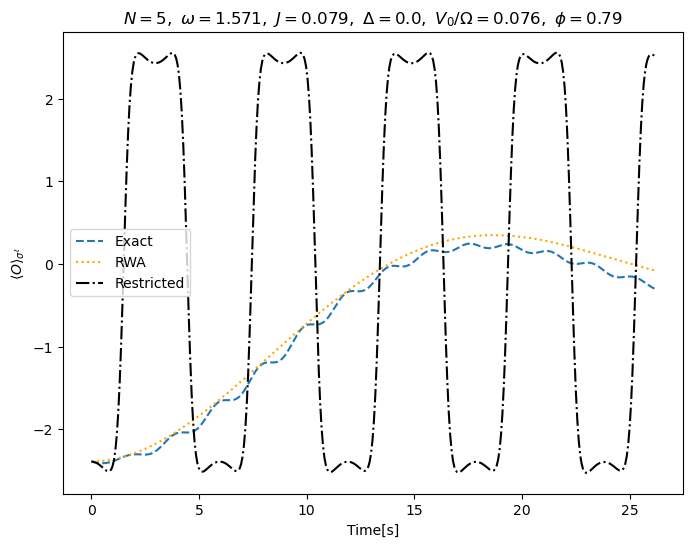

In [56]:
obs1=spin_ops['sy'][2]*spin_ops['sy'][3]
obs=sz_total

obs_evex=np.array([(rho*obs).tr() for rho in rhos_resex])
obs_evrwa=np.array([(sigma*obs).tr() for sigma in rhos_resrwa])
obs_evrot=np.array([(sigma*obs).tr() for sigma in rhos_rotcr])

obs_maxent=np.array([(sigma_t * obs).tr() for sigma_t in sigmas_at_timet])

fig0,ax0=plt.subplots(figsize=(8,6))

plt.plot(timespan, obs_evex, label='Exact', linestyle='dashed')
plt.plot(timespan, obs_evrwa, label='RWA', linestyle='dotted', color='orange')
plt.plot(timespan, obs_maxent, label='Restricted', linestyle='dashdot', color='black')

ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle O \rangle_{\sigma^\ell}$")
plt.title(r'$N={},\,\,\omega={},\,\, J={},\,\, \Delta={},\,\, V_0/\Omega={}, \,\, \phi={}$'.format(
                                                                params['size'],
                                                                round(params['omega'],3), 
                                                                round((params['Jx']),3), 
                                                                round(params['omega']-params['Omega'],3), 
                                                                round(params['V0']/params['Omega'],3),
                                                                round(params['phase'],2)))
plt.show()

In [12]:
z[0]

array([0. +0.j, 1. +0.j, 1. +0.j, 5.2+0.j])